input mole fractions of fuel
H2 fraction = 1
CH4 fraction = 2
C2H6 fraction = 3
C3H8 fraction = 1
equivalence ratio = 2
T (K)= 1200
pressure (Pa, more than 101325)= 150000
burning in air - 1, or oxygen - 2?2
initial parameters of mixture:

  gri30:

       temperature            1200  K
          pressure          150000  Pa
           density        0.431915  kg/m^3
  mean mol. weight         28.7291  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      6.7011e+05        1.925e+07     J
   internal energy      3.2282e+05        9.274e+06     J
           entropy          9882.8        2.839e+05     J/K
    Gibbs function     -1.1189e+07       -3.215e+08     J
 heat capacity c_p          2333.8        6.705e+04     J/K
 heat capacity c_v          2044.4        5.873e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ----

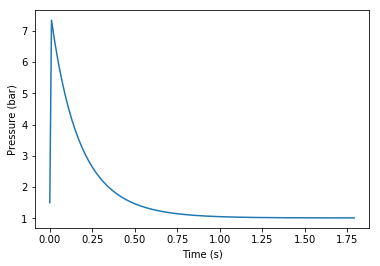

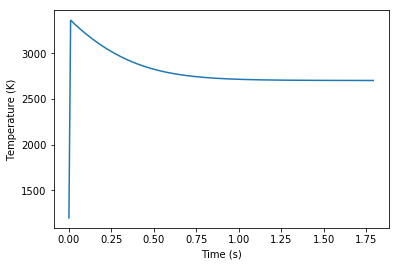

In [3]:
import os
import csv
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

gas = ct.Solution('gri30.xml')
air = ct.Solution('gri30.xml')

air.TPX = 293.15, ct.one_atm, ('O2:1,N2:3.76')
print('input mole fractions of fuel')
h2fr = float(input('H2 fraction = '))
ch4fr = float(input('CH4 fraction = '))
c2h6fr = float(input('C2H6 fraction = '))
c3h8fr = float(input('C3H8 fraction = '))
eq_ratio = float(input('equivalence ratio = '))
temp = float(input('T (K)= '))
press = float(input('pressure (Pa, more than 101425)= '))
oxid = int(input('burning in air - 1, or oxygen - 2?'))

gas.TP = temp, press
if(oxid == 1.0): 
    gas.set_equivalence_ratio(eq_ratio, 'H2:%s,CH4:%s,C2H6:%s,C3H8:%s'%(h2fr,ch4fr,c2h6fr,c3h8fr), 'O2:1.0,N2:3.76')
else: 
    gas.set_equivalence_ratio(eq_ratio, 'H2:%s,CH4:%s,C2H6:%s,C3H8:%s'%(h2fr,ch4fr,c2h6fr,c3h8fr), 'O2:1.0') 

print('initial parameters of mixture:')    
gas()

tank = ct.Reactor(gas)
tank.volume = 1.0
env = ct.Reservoir(air)

outlet = ct.Valve(tank,env)
ro = float(tank.density)
dp = float(tank.thermo.P-env.thermo.P)
outlet.set_valve_coeff((1e-03)*((ro/dp)**(0.5)))

sim = ct.ReactorNet([tank])

print('results of simulation:')
time = 0.0
n = 1
outfile = open('tankleak','w')
csvfile = csv.writer(outfile)
csvfile.writerow(['eq_ratio = %s'%eq_ratio, 'H2fr = %s'%h2fr, 'CH4fr = %s'%ch4fr, 'C2H6fr = %s'%c2h6fr, 'C3H8fr = %s'%c3h8fr])
csvfile.writerow(['n', 'time (s)', 'T (K)', 'P (Pa)'])
states = ct.SolutionArray(gas, extra=['t'])
states.append(tank.thermo.state, t=time)
print('n', 'time(s)','T(K)','P(Pa)')
print('%03.0f'%n, '%4.2f'%time, '%5.2f'%tank.thermo.T, '%6.0f'%tank.thermo.P)
csvfile.writerow(['%02.0f'%n, '%4.2f'%time, '%5.2f'%tank.thermo.T, '%6.0f'%tank.thermo.P])

while tank.thermo.P > (ct.one_atm+100):
    time += 1e-2
    n += 1
    sim.advance(time)
    states.append(tank.thermo.state, t=time)
    print('%03.0f'%n, '%4.2f'%time, '%5.2f'%tank.thermo.T, '%6.0f'%tank.thermo.P)
    csvfile.writerow(['%02.0f'%n, '%4.2f'%time, '%5.2f'%tank.thermo.T, '%6.0f'%tank.thermo.P])

outfile.close()
print('Output written to file tankleak.csv')
print('Directory: '+os.getcwd())

plt.clf()
plt.subplot(1,1,1)
h = plt.plot(states.t, states.P/1e5)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (bar)')
plt.show()
plt.subplot(1,1,1)
plt.plot(states.t, states.T)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.show()